# Games Recommender System

Steam is an online platform which allows users to purchase games to play. Steam would presumably profit from each game purchase by taking a cut from the sale. When gamers procure in-game items, Steam would also likely take a share of the sale. 

Assuming the above business model to be true, it would be in Steam's interest to recommend games to users to purchase and to also recommend games that users would spend a long time playing to increase the likelihood of them purchasing in-game items to elevate their gaming experience. 

As such, a games recommender system is developed with a dataset of games purchased and cumulative play time of various users obtained from Steam. In this project, a hybrid games recommender system would be developed using a number of possible recommender algorithms to deploy a three-pronged approach so as to increase the likelihood of a user finding a game he/she would like to purchase and play. These include:
1. Top Seller Recommender  (based on top purchases)
2. Community Recommender (based on top play times)
3. Neural Collaborative Filtering Recommender (using Deep Neural Network and based on user-game interactions)


## Setup

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

## Loading Data

In [2]:
games = pd.read_csv("steam-200k.csv", header=None)
games.head(10)

,0,1,2,3,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0
5,151603712,Spore,play,14.9,0
6,151603712,Fallout New Vegas,purchase,1.0,0
7,151603712,Fallout New Vegas,play,12.1,0
8,151603712,Left 4 Dead 2,purchase,1.0,0
9,151603712,Left 4 Dead 2,play,8.9,0


The following information has been provided for the above data:
- Column 0: User ID
- Column 1: Game title
- Column 2: User Action {'purchase','play'}
- Column 3: Value. Value is 1 if Column 2 is 'purchase' or number of hours the user has played the game if Column 2 is 'play'.

In [3]:
games.describe()

,0,3,4
count,2.000000e+05,200000.000000,200000.0
mean,1.036559e+08,17.874384,0.0
std,7.208074e+07,138.056952,0.0
min,5.250000e+03,0.100000,0.0
25%,4.738420e+07,1.000000,0.0
50%,8.691201e+07,1.000000,0.0
75%,1.542309e+08,1.300000,0.0
max,3.099031e+08,11754.000000,0.0


As shown above, column 4 is filled with all zeroes. As such, we can drop column 4 and rename the remaining columns so that it will be easier to understand the data. 

In [4]:
games = games.drop(4, axis=1)
games = games.rename(columns= {0: 'userid', 1: 'game', 2: 'action', 3: 'value'})
games.head(10)

,userid,game,action,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
5,151603712,Spore,play,14.9
6,151603712,Fallout New Vegas,purchase,1.0
7,151603712,Fallout New Vegas,play,12.1
8,151603712,Left 4 Dead 2,purchase,1.0
9,151603712,Left 4 Dead 2,play,8.9


## Data Exploration

In [5]:
userNum = len(games['userid'].unique())
gameNum = len(games['game'].unique())
dataNum = games.shape[0]
print(f"The dataset has {dataNum} data, containing information about {userNum} users and {gameNum} games.")
purchaseNum = len(games[games['action']=="purchase"])
playNum = len(games[games['action']=="play"])
print(f"The dataset has {purchaseNum} records of purchases and {playNum} records of play times.")

The dataset has 200000 data, containing information about 12393 users and 5155 games.
The dataset has 129511 records of purchases and 70489 records of play times.


As shown above, there are more purchases made than plays, which seems to indicate that there are instances of users who purchase games without playing them.

In [6]:
play = games[games["action"]=="play"].copy()
purchase = games[games["action"]=="purchase"].copy()
sortedpurchase = purchase.groupby('game')['game'].agg('count').sort_values(ascending=False)
sortedplay = play.groupby('game')['value'].agg(np.sum).sort_values(ascending=False)

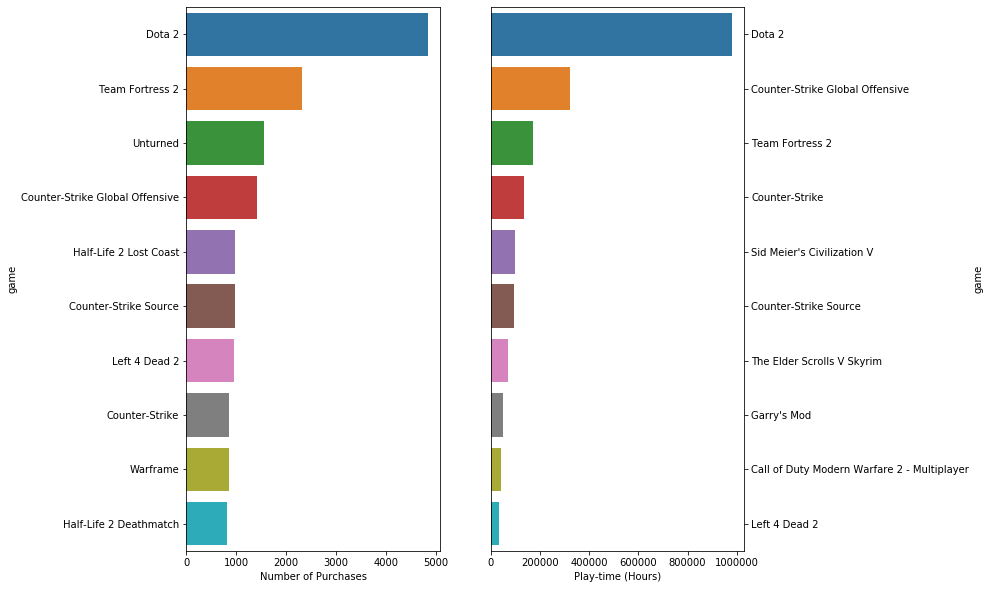

In [7]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
sns.barplot(y = sortedpurchase.index[:10], x = sortedpurchase.values[:10], ax=ax[0])
sns.barplot(y = sortedplay.index[:10], x = sortedplay.values[:10], ax=ax[1])
ax[0].set(xlabel="Number of Purchases")
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set(xlabel="Play-time (Hours)")
plt.show()

For the top 10 games purchased and played, a disconnect can be seen in that the top game purchases do not necessarily translate into long play times. As such, instead of recommending just the top games purchased, we should also recommend the top games played as well. 

Let's extract a random user from the data first so that we can test the recommenders developed in the subsequent sections. Before that, let's take a look at the top 10 games played by the user. 

In [10]:
def userHistory(testuser):
    allgames = set(play['game'])
    
    userpurchased = set(purchase[purchase["userid"]==testuser]["game"])
    notpurchased = allgames - userpurchased
    
    userplayed = set(play[play["userid"]==testuser]["game"])
    notplayed = allgames - userplayed

    userhours = play[play["userid"]==testuser].sort_values(by='value', ascending =False)
    print(f"Top 10 games played by user {testuser}:")
    for row in userhours[:10].itertuples():
        print(row.game, ":", row.value, "hours")    
    return userpurchased, notpurchased, userplayed, notplayed

testuser = play["userid"].sample(1).iloc[0]
userpurchased, notpurchased, userplayed, notplayed = userHistory(testuser)



Top 10 games played by user 164761364:
DayZ : 92.0 hours
Age of Empires II HD Edition : 55.0 hours
Counter-Strike Global Offensive : 48.0 hours
Left 4 Dead 2 : 33.0 hours
7 Days to Die : 31.0 hours
Stronghold Crusader HD : 25.0 hours
No More Room in Hell : 21.0 hours
Sins of a Solar Empire Rebellion : 15.2 hours
Unturned : 12.4 hours
Anno 1404 Venice : 8.6 hours


## Top Seller Recommender

There is a possibility that a user might be interested in top selling games on the Steam platform since there are so many other users purchasing them. As such, a Top Seller Recommender would promote the top sellers which the test user has not purchased.   

In [11]:
def TopSeller(testuser):
    
    TopGames = []
    i = 0
    while len(TopGames) < 11:
        if sortedpurchase.index[i] in notpurchased:
            TopGames.append(sortedpurchase.index[i])
        i += 1
    print(f"\nTop Sellers recommended to user {testuser}:")
    for game in TopGames:
        print(game) 

In [12]:
TopSeller(testuser)


Top Sellers recommended to user 164761364:
Half-Life 2 Lost Coast
Counter-Strike Source
Counter-Strike
Half-Life 2 Deathmatch
Garry's Mod
The Elder Scrolls V Skyrim
Robocraft
Counter-Strike Condition Zero
Counter-Strike Condition Zero Deleted Scenes
Half-Life 2
Sid Meier's Civilization V


## Community Recommender

As observed in the data, top sellers might not necessarily translate into top games played. Besides recommending the top sellers, we should also consider recommending top 10 games played by the community of gamers which the user has not purchased.  

In [13]:
def Comm(testuser):
    
    PopGames = []
    i = 0
    while len(PopGames) < 11:
        if sortedplay.index[i] in notpurchased:
            PopGames.append(sortedplay.index[i])
        i += 1
        
    print(f"\nTop 10 popular games recommended by the community to user {testuser}:")
    for game in PopGames:
        print(game) 

In [14]:
Comm(testuser)


Top 10 popular games recommended by the community to user 164761364:
Counter-Strike
Sid Meier's Civilization V
Counter-Strike Source
The Elder Scrolls V Skyrim
Garry's Mod
Call of Duty Modern Warfare 2 - Multiplayer
Football Manager 2013
Football Manager 2012
Football Manager 2014
Terraria
Football Manager 2015


The top 10 games recommended by the Top Seller Recommender and Community Recommender are different, which helps to cover more bases and increase the likelihood that the test user might be interested in one of the recommended games. 

## Neural Collaborative Filtering Recommender

A common drawback with the Top Seller and Community Recommenders is that they have not considered the games that a given user has played. As such, we can refine the recommendation approach to account for not just the games played, but also the number of hours played for each game. This can be achieved by using deep neural network to perform collaborative filtering. 

Collaborative filtering is a technique used to filter out items which a given user might be interested in given that there are other users with similar preferences as the given user. For instance, user A might have played Counter-Strike, Call of Duty and Team Fortress, while user B might have played Counter-Strike and Team Fortress. In this case, there is a high possibility that user B might be interested in Call of Duty since both users have played similar games.

To achieve this, a deep learning model has been developed to take in two sparse vectors as inputs:
- User vector
- Game vector

Embedding layers are added next to obtain the latent vectors for the sparse inputs from the input layer. The latent vectors would go through the multiple layered neural network to map to the predicted probabilities. Lastly, a dot layer is added to determine the probable hours that a given user would play a given game.  

In [15]:
#obtain list of users and games
userlist = list(play['userid'].unique())
gamelist = list(play['game'].unique())

#perform integer encoding on users and games
enc_user = {user: encodeidx for encodeidx, user in enumerate(userlist)}
enc_game = {game: encodeidx for encodeidx, game in enumerate(gamelist)}

#map userid and game in games dataframe to the respective encoded integer
play['enc_user'] = play['userid'].map(enc_user)
play['enc_game'] = play['game'].map(enc_game)

#apply sigmoid transformation on the play time to address the skew in data
def sigmoid(x):
    e = np.exp(1)
    y = 1/(1+e**(-x))
    return y

play['value_norm'] = sigmoid(play['value'])
play

,userid,game,action,value,enc_user,enc_game,value_norm
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0,0,1.000000
3,151603712,Fallout 4,play,87.0,0,1,1.000000
5,151603712,Spore,play,14.9,0,2,1.000000
7,151603712,Fallout New Vegas,play,12.1,0,3,0.999994
9,151603712,Left 4 Dead 2,play,8.9,0,4,0.999864
...,...,...,...,...,...,...,...
199991,128470551,Fallen Earth,play,2.4,11349,1349,0.916827
199993,128470551,Magic Duels,play,2.2,11349,1289,0.900250
199995,128470551,Titan Souls,play,1.5,11349,1274,0.817574
199997,128470551,Grand Theft Auto Vice City,play,1.5,11349,1004,0.817574


In [16]:
x = play[['enc_user','enc_game']].values
y = play['value_norm'].values

#use 70% of data to train model and reserve remaining 30% for validation of model
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=88)

#as there will be 2 inputs to the deep learning model used to predict ratings, we will split x_train and x_test into 2 sub-arrays
x_train_array = [x_train[:, 0], x_train[:, 1]]
x_test_array = [x_test[:, 0], x_test[:, 1]]

In [17]:
def NCFModel(num_users, num_games, num_factors=30):
    user = Input(shape=(1,))
    u = Embedding(num_users, num_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((num_factors,))(u)

    game = Input(shape=(1,))
    g = Embedding(num_games, num_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(game)
    g = Reshape((num_factors,))(g)

    result = Dot(axes=1)([u,g])

    model = Model(inputs=[user,game], outputs=result)
    opt = Adam(lr=0.001)
    model.compile(loss="mean_squared_error", optimizer=opt)
    
    return model

In [18]:
num_users = len(userlist)
num_games = len(gamelist)

model = NCFModel(num_users, num_games)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 30)        340500      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 30)        108000      input_2[0][0]                    
______________________________________________________________________________________________

In [19]:
history = model.fit(x=x_train_array, y=y_train, batch_size=64, epochs=5, verbose=2, validation_data=(x_test_array, y_test))


Epoch 1/5
771/771 - 4s - loss: 0.7023 - val_loss: 0.4118
Epoch 2/5
771/771 - 3s - loss: 0.2319 - val_loss: 0.1974
Epoch 3/5
771/771 - 3s - loss: 0.0964 - val_loss: 0.1572
Epoch 4/5
771/771 - 3s - loss: 0.0529 - val_loss: 0.1425
Epoch 5/5
771/771 - 3s - loss: 0.0368 - val_loss: 0.1371


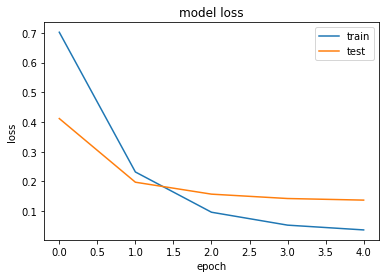

In [20]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [21]:
def NCFRec(testuser):
    
    #obtain encoded integer for given userId
    testuser_enc = enc_user.get(testuser)
    
    #find games which have not been played by given user
    notplayedenc = [[enc_game.get(x)] for x in notplayed]

    #create input for model
    user_game_array = np.hstack(([[testuser_enc]] * len(notplayed), notplayedenc))
    
    #use developed model to predict hours played for given user 
    user_hours = model.predict([user_game_array[:,0], user_game_array[:,1]]).flatten()

    #find top 10 games based on predicted hours for given user
    top_hours = user_hours.argsort()[::-1]
    topgameids = [notplayedenc[x][0] for x in top_hours]
    recommended_games = play[play["enc_game"].isin(topgameids)][:10]
    print(f"\nTop 10 games recommended to user {testuser}:")
    for row in recommended_games.itertuples():
        print(row.game) 

In [22]:
NCFRec(testuser)


Top 10 games recommended to user 164761364:
The Elder Scrolls V Skyrim
Fallout 4
Spore
Fallout New Vegas
HuniePop
Path of Exile
Poly Bridge
Left 4 Dead
Tomb Raider
The Banner Saga


## Hybrid Recommender

By stringing together the above recommenders, we can develop a Hybrid Recommender using a three-pronged approach to increase the likelihood that the user would be interested in one of the recommended games. 

In [23]:
def hybrid(testuser):
    userpurchased, notpurchased, userplayed, notplayed = userHistory(testuser)
    TopSeller(testuser)
    Comm(testuser)
    NCFRec(testuser)

In [24]:
hybrid(testuser)

Top 10 games played by user 164761364:
DayZ : 92.0 hours
Age of Empires II HD Edition : 55.0 hours
Counter-Strike Global Offensive : 48.0 hours
Left 4 Dead 2 : 33.0 hours
7 Days to Die : 31.0 hours
Stronghold Crusader HD : 25.0 hours
No More Room in Hell : 21.0 hours
Sins of a Solar Empire Rebellion : 15.2 hours
Unturned : 12.4 hours
Anno 1404 Venice : 8.6 hours

Top Sellers recommended to user 164761364:
Half-Life 2 Lost Coast
Counter-Strike Source
Counter-Strike
Half-Life 2 Deathmatch
Garry's Mod
The Elder Scrolls V Skyrim
Robocraft
Counter-Strike Condition Zero
Counter-Strike Condition Zero Deleted Scenes
Half-Life 2
Sid Meier's Civilization V

Top 10 popular games recommended by the community to user 164761364:
Counter-Strike
Sid Meier's Civilization V
Counter-Strike Source
The Elder Scrolls V Skyrim
Garry's Mod
Call of Duty Modern Warfare 2 - Multiplayer
Football Manager 2013
Football Manager 2012
Football Manager 2014
Terraria
Football Manager 2015

Top 10 games recommended to us